# Decision Trees for Big Data Analytics

*Wannes Meert, Hendrik Blockeel, KU Leuven, 2023*

Examples based on [KU Leuven course Machine Learning and Inductive Inference (Hendrik Blockeel)](https://onderwijsaanbod.kuleuven.be/syllabi/e/H02C1AE.htm#activetab=doelstellingen_idp50160), [scikit-learn documentation](https://scikit-learn.org/stable/index.html) and [pandas documentation](http://pandas.pydata.org).

## Part 4: Ensembles of Decision Trees -- Gradient Boosting Trees

### Setup

Set the path where the notebooks are located. If the printed path is incorrect, change the code.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/wannesm/KTU_Notebooks

In [1]:
from pathlib import Path
nb_path_options = [Path("."), Path(".") / "KTU_Notebooks"]
nb_path = None
for nb_path_option  in nb_path_options:
    test_path = nb_path_option / "rsrc" / "drinks.csv"
    if test_path.exists():
        nb_path = nb_path_option
        continue
if nb_path is None or not nb_path.exists():
      print("Path to notebooks not found")
else:
      print(f"Path to notebooks: {nb_path.absolute()}")

Path to notebooks: /Users/wannes/Nextcloud/Documents/Events/2023/2023-KTU-BigDataSchool/KTU_BigDataSchool_Meert_Exercises/Notebooks


In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

### Learning a Gradient Boosting Tree

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

In [5]:
np.random.seed(1)
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
y = (X * np.sin(X)).ravel()

In [6]:
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

In [8]:
clf = GradientBoostingRegressor(loss='squared_error',
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
clf.fit(X, y);

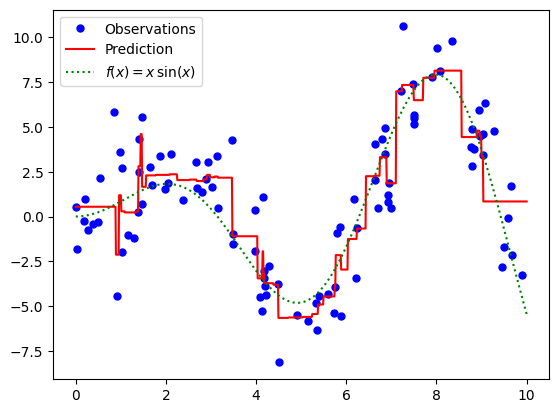

In [9]:
x_int = np.atleast_2d(np.linspace(0, 10, 1000)).T
y_pred = clf.predict(x_int)
plt.plot(X, y, 'b.', markersize=10, label='Observations');
plt.plot(x_int, y_pred, 'r-', label='Prediction');
plt.plot(x_int, x_int * np.sin(x_int), 'g:', label=r'$f(x) = x\,\sin(x)$')
plt.legend(loc='upper left');

#### Gradient Boosted Trees for the Adults Dataset

We will now work with a more 'real-world' dataset that has missing column names, missing data, categorical and continues attributes, ...

The dataset can be downloaded directly from the popular UCI archive:

In [10]:
base_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/"
data_train = pd.read_csv(base_url + "adult.data", header = None)
data_test = pd.read_csv(base_url + "adult.test",  header = None, skiprows = 1)

In [11]:
data_train_orig = data_train.copy()
data_test_orig = data_test.copy()

In [12]:
data_train = data_train_orig.copy()
data_test = data_test_orig.copy()

In [13]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


The column names are available from the dataset description: https://archive.ics.uci.edu/ml/datasets/Adult

In [14]:
attribute_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                   'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                   'hours_per_week', 'native_country', 'wage_class']
data_train.columns = attribute_names
data_test.columns = attribute_names

Missing data is indicated with a question mark. For example, for the work class attribute there are 1836 instances with a missing value out of 32561 instances.

In [15]:
np.sum(data_train['workclass'] == " ?"), data_train.shape[0]

(1836, 32561)

Not all classifiers can deal with missing values. Two other options are to replace them with other values (e.g. the mean value of the attribute) or to drop instances with missing values. For simplicity, we'll drop instances with missing values here.

In [16]:
data_train = data_train.replace(' ?', np.nan).dropna()
data_test = data_test.replace(' ?', np.nan).dropna()

There is also a mismatch between the strings used for the wage class in the training and test set. We can align them using:

In [17]:
data_test['wage_class'] = data_test['wage_class'].replace({' <=50K.': ' <=50K',
                                                           ' >50K.':' >50K'})

Scikit-learn only accepts numerical feature values, so we'll replace all strings by an integer representing that string. In some cases it might be better to use one-hot-encoding instead of a categorical encoding. For trees, however, there is not much of a difference (because of the splitting).

In [18]:
feature_categories = {}

for feature in data_train.columns:
    print(f"Feature {feature}: type = {data_train[feature].dtype}")
    if data_train[feature].dtype == 'object':
        categorical = pd.Categorical(data_train[feature])
        print(f"Replace strings with integers: {categorical.categories}")
        feature_categories[feature] = categorical.categories
        data_train[feature] = categorical.codes
        data_test[feature] = pd.Categorical(data_test[feature], categories=categorical.categories).codes

Feature age: type = int64
Feature workclass: type = object
Replace strings with integers: Index([' Federal-gov', ' Local-gov', ' Private', ' Self-emp-inc',
       ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
      dtype='object')
Feature fnlwgt: type = int64
Feature education: type = object
Replace strings with integers: Index([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th',
       ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad',
       ' Masters', ' Preschool', ' Prof-school', ' Some-college'],
      dtype='object')
Feature education_num: type = int64
Feature marital_status: type = object
Replace strings with integers: Index([' Divorced', ' Married-AF-spouse', ' Married-civ-spouse',
       ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed'],
      dtype='object')
Feature occupation: type = object
Replace strings with integers: Index([' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial',
       ' Farmi

In [19]:
data_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0


In [20]:
data_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,2,226802,1,7,4,6,3,2,1,0,0,40,38,0
1,38,2,89814,11,9,2,4,0,4,1,0,0,50,38,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,38,1
3,44,2,160323,15,10,2,6,0,2,1,7688,0,40,38,1
5,34,2,198693,0,6,4,7,1,4,1,0,0,30,38,0


Verify that all features are numeric.

In [21]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30162 non-null  int64
 1   workclass       30162 non-null  int8 
 2   fnlwgt          30162 non-null  int64
 3   education       30162 non-null  int8 
 4   education_num   30162 non-null  int64
 5   marital_status  30162 non-null  int8 
 6   occupation      30162 non-null  int8 
 7   relationship    30162 non-null  int8 
 8   race            30162 non-null  int8 
 9   sex             30162 non-null  int8 
 10  capital_gain    30162 non-null  int64
 11  capital_loss    30162 non-null  int64
 12  hours_per_week  30162 non-null  int64
 13  native_country  30162 non-null  int8 
 14  wage_class      30162 non-null  int8 
dtypes: int64(6), int8(9)
memory usage: 1.9 MB


We can now feed the data to the classifier. We welect the wage_class as the target for the classifier.

In [22]:
target_train = data_train.pop('wage_class')
target_test = data_test.pop('wage_class')

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
clf = GradientBoostingClassifier(n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
clf.fit(data_train, target_train);

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
test_pred = clf.predict(data_test)
acc_test = accuracy_score(test_pred, target_test)
print(f"Accuracy for test set: {acc_test}")

Accuracy for test set: 0.8686586985391767
